# Roboflow Dataset Augmentation and Synthetic Data Generation

This notebook augments the Roboflow dataset using:
1. **Traditional augmentations:** horizontal flip, vertical flip, rotation, tilt, brightness
2. **Synthetic data generation:** 30% augmented images + 70% completely synthetic images

**Pipeline:**
1. **Configuration:** Set up paths and parameters
2. **Analyze Dataset:** Check class distribution in roboflow dataset
3. **Traditional Augmentation:** Apply standard image transformations
4. **Synthetic Generation:** Generate synthetic images using object bank
5. **Balance Classes:** Ensure all classes are balanced
6. **Create Final Dataset:** roboflow_augmented with balanced /train and copied /test

In [11]:
import os
import json
import cv2
import numpy as np
import yaml
from PIL import Image, ImageDraw, ImageEnhance
import random
import shutil
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict, Counter
from pathlib import Path
import albumentations as A

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Configuration

In [12]:
from pathlib import Path

# --- Paths ---
BASE_DIR = Path('/home/andrea/work/AI-waste-detection/')
ROBOFLOW_DIR = BASE_DIR / 'src/data_processing/roboflow'  # Source dataset
ROBOFLOW_AUGMENTED_DIR = BASE_DIR / 'src/data_processing/roboflow_augmented'  # Output dataset
OBJECT_BANK_DIR = BASE_DIR / 'datasets/object_bank_for_balancing'  # Pre-existing object bank

# --- Generation Parameters ---
IMAGE_SIZE = (640, 640)
OBJECTS_PER_IMAGE_RANGE = (2, 7)
SCALE_RANGE = (0.2, 0.7)
ROTATION_RANGE = (-20, 20)
OVERLAP_THRESHOLD = 0.05

# --- Augmentation Parameters ---
HORIZONTAL_FLIP_PROB = 0.5
VERTICAL_FLIP_PROB = 0.5
ROTATION_PROB = 0.25  # 25% chance for 0,90,180,270 rotation
TILT_RANGE = (-15, 15)  # degrees
BRIGHTNESS_RANGE = (0.92, 1.08)  # ±8% brightness change

# --- Synthetic Data Distribution ---
AUGMENTED_SYNTHETIC_RATIO = 0.7  # 30% augmented images
PURE_SYNTHETIC_RATIO = 0.3       # 70% pure synthetic images

# Create directories
ROBOFLOW_AUGMENTED_DIR.mkdir(exist_ok=True)

print(f"Source Roboflow Directory: {ROBOFLOW_DIR}")
print(f"Output Augmented Directory: {ROBOFLOW_AUGMENTED_DIR}")
print(f"Object Bank Directory: {OBJECT_BANK_DIR}")

# Check if source exists
if not ROBOFLOW_DIR.exists():
    print(f"❌ ERROR: Source dataset not found at {ROBOFLOW_DIR}")
else:
    print(f"✅ Source dataset found")
    
if not OBJECT_BANK_DIR.exists():
    print(f"❌ WARNING: Object bank not found at {OBJECT_BANK_DIR}")
    print("  You may need to run synthetic_data_generation.ipynb first to create the object bank")
else:
    print(f"✅ Object bank found")

Source Roboflow Directory: /home/andrea/work/AI-waste-detection/src/data_processing/roboflow
Output Augmented Directory: /home/andrea/work/AI-waste-detection/src/data_processing/roboflow_augmented
Object Bank Directory: /home/andrea/work/AI-waste-detection/datasets/object_bank_for_balancing
✅ Source dataset found
✅ Object bank found


## 2. Analyze Original Dataset

📊 Analyzing Original Roboflow Dataset...
Target classes from data.yaml: ['glass', 'metal', 'organic', 'paper', 'plastic']

Original Train Set Distribution:
  - glass (ID 0): 445 instances
  - metal (ID 1): 1775 instances
  - organic (ID 2): 597 instances
  - paper (ID 3): 1037 instances
  - plastic (ID 4): 2420 instances

Original Test Set Distribution:
  - glass (ID 0): 109 instances
  - metal (ID 1): 489 instances
  - organic (ID 2): 163 instances
  - paper (ID 3): 241 instances
  - plastic (ID 4): 620 instances

Original Train Set Distribution:
  - glass (ID 0): 445 instances
  - metal (ID 1): 1775 instances
  - organic (ID 2): 597 instances
  - paper (ID 3): 1037 instances
  - plastic (ID 4): 2420 instances

Original Test Set Distribution:
  - glass (ID 0): 109 instances
  - metal (ID 1): 489 instances
  - organic (ID 2): 163 instances
  - paper (ID 3): 241 instances
  - plastic (ID 4): 620 instances


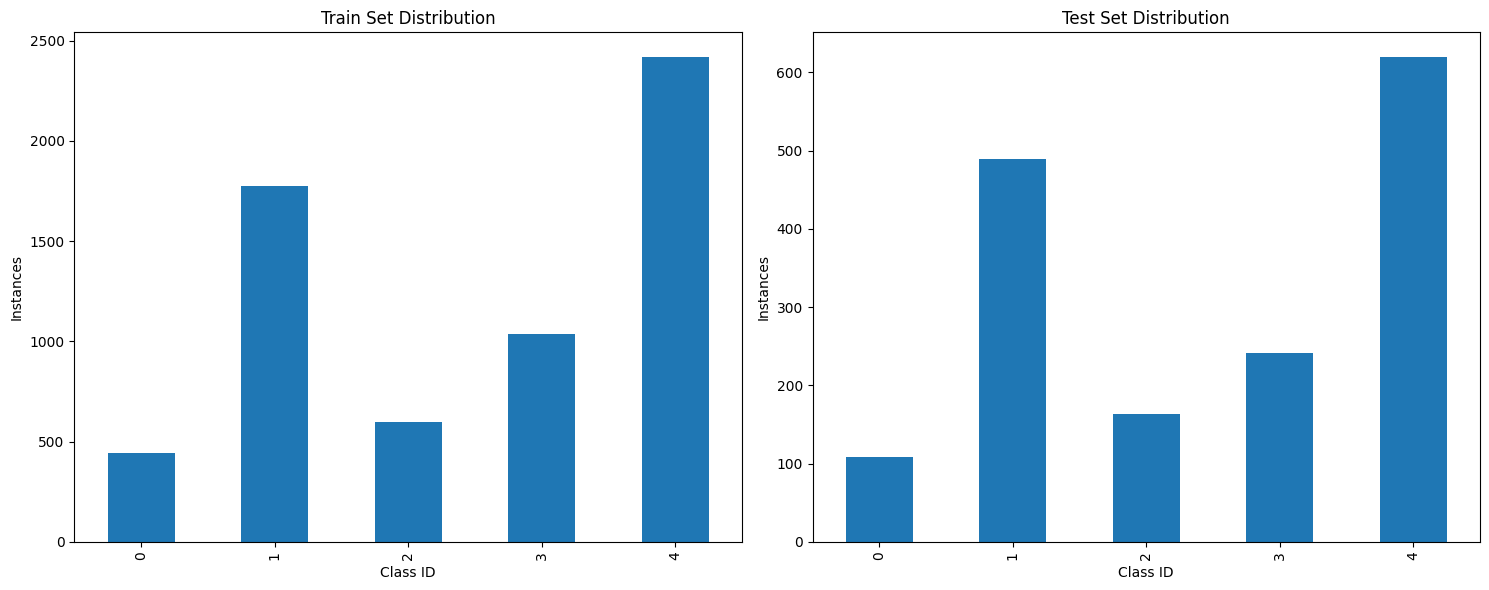

In [13]:
def load_dataset_config(dataset_dir):
    """Loads the data.yaml file from the dataset directory."""
    config_path = dataset_dir / 'data.yaml'
    if not config_path.exists():
        raise FileNotFoundError(f"data.yaml not found in {dataset_dir}")
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
    return config

def get_class_distribution(labels_dir, num_classes):
    """Counts class instances in a directory of YOLO label files."""
    class_counts = Counter()
    if not labels_dir.is_dir():
        return class_counts
    for label_file in labels_dir.glob('*.txt'):
        with open(label_file, 'r') as f:
            for line in f:
                if line.strip():
                    # Convert to float first, then to int to handle cases like '4.0'
                    class_id = int(float(line.split()[0]))
                    if class_id < num_classes:
                        class_counts[class_id] += 1
    return class_counts

def analyze_dataset_distribution():
    """Analyze the class distribution of the original roboflow dataset."""
    print("📊 Analyzing Original Roboflow Dataset...")
    
    try:
        dataset_config = load_dataset_config(ROBOFLOW_DIR)
        target_classes = dataset_config.get('names', [])
        num_classes = len(target_classes)
        print(f"Target classes from data.yaml: {target_classes}")
        
        # Analyze train set
        train_labels_dir = ROBOFLOW_DIR / 'train/labels'
        train_distribution = get_class_distribution(train_labels_dir, num_classes)
        
        # Analyze test set
        test_labels_dir = ROBOFLOW_DIR / 'test/labels'
        test_distribution = get_class_distribution(test_labels_dir, num_classes)
        
        print(f"\nOriginal Train Set Distribution:")
        for i, class_name in enumerate(target_classes):
            print(f"  - {class_name} (ID {i}): {train_distribution[i]} instances")
            
        print(f"\nOriginal Test Set Distribution:")
        for i, class_name in enumerate(target_classes):
            print(f"  - {class_name} (ID {i}): {test_distribution[i]} instances")
        
        # Plot distributions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Train distribution
        if train_distribution:
            train_df = pd.DataFrame.from_dict(train_distribution, orient='index').sort_index()
            train_df.plot(kind='bar', legend=False, ax=ax1, title='Train Set Distribution')
            ax1.set_xlabel('Class ID')
            ax1.set_ylabel('Instances')
            
        # Test distribution
        if test_distribution:
            test_df = pd.DataFrame.from_dict(test_distribution, orient='index').sort_index()
            test_df.plot(kind='bar', legend=False, ax=ax2, title='Test Set Distribution')
            ax2.set_xlabel('Class ID')
            ax2.set_ylabel('Instances')
            
        plt.tight_layout()
        plt.show()
        
        return target_classes, num_classes, train_distribution, test_distribution
        
    except Exception as e:
        print(f"❌ Error analyzing dataset: {e}")
        return [], 0, {}, {}

# Analyze the dataset
TARGET_CLASSES, NUM_CLASSES, train_dist, test_dist = analyze_dataset_distribution()

## 3. Traditional Augmentation Functions

In [14]:
def parse_yolo_label(label_line, img_width, img_height):
    """Parse a YOLO label line into absolute coordinates."""
    parts = label_line.strip().split()
    # Convert to float first, then to int to handle cases like '4.0'
    class_id = int(float(parts[0]))
    cx, cy, w, h = map(float, parts[1:5])
    
    # Convert to absolute coordinates
    x1 = int((cx - w/2) * img_width)
    y1 = int((cy - h/2) * img_height)
    x2 = int((cx + w/2) * img_width)
    y2 = int((cy + h/2) * img_height)
    
    return class_id, [x1, y1, x2, y2]

def bbox_to_yolo(bbox, img_width, img_height):
    """Convert absolute bbox to YOLO format."""
    x1, y1, x2, y2 = bbox
    cx = (x1 + x2) / 2 / img_width
    cy = (y1 + y2) / 2 / img_height
    w = (x2 - x1) / img_width
    h = (y2 - y1) / img_height
    return cx, cy, w, h

def apply_traditional_augmentations(img_path, label_path, output_img_dir, output_label_dir, base_filename):
    """Apply traditional augmentations to an image and its labels."""
    # Load image
    image = cv2.imread(str(img_path))
    if image is None:
        return []
    
    # Convert BGR to RGB for albumentations
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_height, img_width = image.shape[:2]
    
    # Load labels
    bboxes = []
    class_labels = []
    
    if label_path.exists():
        with open(label_path, 'r') as f:
            for line in f:
                if line.strip():
                    class_id, bbox = parse_yolo_label(line, img_width, img_height)
                    # Convert to normalized format [x_min, y_min, x_max, y_max] for albumentations
                    x1, y1, x2, y2 = bbox
                    norm_bbox = [x1/img_width, y1/img_height, x2/img_width, y2/img_height]
                    bboxes.append(norm_bbox)
                    class_labels.append(class_id)
    
    augmented_files = []
    
    # Define augmentation compositions with bbox_params
    transform_configs = [
        # Horizontal flip
        (A.HorizontalFlip(p=1.0), HORIZONTAL_FLIP_PROB),
        # Vertical flip  
        (A.VerticalFlip(p=1.0), VERTICAL_FLIP_PROB),
        # Random rotation (0, 90, 180, 270)
        (A.RandomRotate90(p=1.0), ROTATION_PROB),
        # Tilt (affine rotation)
        (A.Affine(rotate=random.uniform(*TILT_RANGE), p=1.0), 1.0),
        # Brightness change
        (A.RandomBrightnessContrast(
            brightness_limit=(BRIGHTNESS_RANGE[0]-1, BRIGHTNESS_RANGE[1]-1),
            contrast_limit=0,
            p=1.0
        ), 1.0)
    ]
    
    # Apply augmentations
    for aug_idx, (augmentation, prob) in enumerate(transform_configs):
        if random.random() >= prob:
            continue
            
        try:
            # Create composition with bbox parameters
            transform = A.Compose([augmentation], 
                                bbox_params=A.BboxParams(format='albumentations', 
                                                       label_fields=['class_labels'],
                                                       min_visibility=0.1))
            
            # Apply augmentation
            if len(bboxes) > 0:
                augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
                aug_image = augmented['image']
                aug_bboxes = augmented['bboxes']
                aug_class_labels = augmented['class_labels']
            else:
                # If no bboxes, just transform the image
                augmented = transform(image=image, bboxes=[], class_labels=[])
                aug_image = augmented['image']
                aug_bboxes = []
                aug_class_labels = []
            
            # Convert back to BGR for saving
            aug_image_bgr = cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR)
            
            # Save augmented image
            aug_filename = f"{base_filename}_aug_{aug_idx}"
            aug_img_path = output_img_dir / f"{aug_filename}.jpg"
            aug_label_path = output_label_dir / f"{aug_filename}.txt"
            
            cv2.imwrite(str(aug_img_path), aug_image_bgr)
            
            # Save augmented labels
            with open(aug_label_path, 'w') as f:
                for class_id, norm_bbox in zip(aug_class_labels, aug_bboxes):
                    # Convert normalized bbox back to absolute coordinates
                    x1_norm, y1_norm, x2_norm, y2_norm = norm_bbox
                    x1 = x1_norm * aug_image.shape[1]
                    y1 = y1_norm * aug_image.shape[0]
                    x2 = x2_norm * aug_image.shape[1]
                    y2 = y2_norm * aug_image.shape[0]
                    
                    # Convert to YOLO format
                    cx, cy, w, h = bbox_to_yolo([x1, y1, x2, y2], aug_image.shape[1], aug_image.shape[0])
                    f.write(f"{class_id} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}\n")
            
            augmented_files.append((aug_img_path, aug_label_path))
            
        except Exception as e:
            print(f"Failed to apply augmentation {aug_idx}: {e}")
            continue
    
    return augmented_files

## 4. Synthetic Data Generation (Based on synthetic_data_generation.ipynb)

In [15]:
def load_object_bank():
    """Loads the paths of all objects in the bank, organized by class name."""
    object_bank = defaultdict(list)
    print("🔎 Loading Object Bank...")
    if not OBJECT_BANK_DIR.exists():
        print("  Object bank directory not found.")
        return object_bank
        
    for class_dir in OBJECT_BANK_DIR.iterdir():
        if class_dir.is_dir():
            for obj_file in class_dir.glob('*.png'):
                object_bank[class_dir.name].append(obj_file)
    
    print("  Object Bank loaded successfully.")
    for class_name, objects in object_bank.items():
        print(f"  - Found {len(objects)} objects for class '{class_name}'")
    return object_bank

def create_gradient_background(size):
    """Creates a background with a random linear gradient."""
    width, height = size
    color1 = np.random.randint(150, 255, 3)
    color2 = np.random.randint(150, 255, 3)
    
    background = np.zeros((height, width, 3), dtype=np.uint8)
    for y in range(height):
        ratio = y / height
        color = (color1 * (1 - ratio) + color2 * ratio).astype(np.uint8)
        background[y, :] = color
        
    return Image.fromarray(background)

def calculate_iou(box1, box2):
    """Calculates IoU for two boxes in (x1, y1, x2, y2) format."""
    x1_i = max(box1[0], box2[0])
    y1_i = max(box1[1], box2[1])
    x2_i = min(box1[2], box2[2])
    y2_i = min(box1[3], box2[3])
    
    inter_area = max(0, x2_i - x1_i) * max(0, y2_i - y1_i)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area
    
    return inter_area / union_area if union_area > 0 else 0

def generate_pure_synthetic_image(object_bank, classes_to_add, image_size):
    """Generates a completely synthetic image with gradient background."""
    background = create_gradient_background(image_size)
    placed_object_bboxes = []
    yolo_annotations = []

    for class_name in classes_to_add:
        if class_name not in TARGET_CLASSES:
            continue
        class_id = TARGET_CLASSES.index(class_name)
        
        if not object_bank[class_name]: 
            continue

        obj_path = random.choice(object_bank[class_name])
        obj_img = Image.open(obj_path)

        # Random transformations
        scale = random.uniform(*SCALE_RANGE)
        new_size = (int(image_size[0] * scale), int(image_size[1] * scale))
        obj_img.thumbnail(new_size, Image.Resampling.LANCZOS)
        rotation = random.uniform(*ROTATION_RANGE)
        obj_img = obj_img.rotate(rotation, expand=True, resample=Image.Resampling.BICUBIC)

        # Find a valid placement
        for _ in range(50): # 50 attempts
            pos_x = random.randint(0, image_size[0] - obj_img.width)
            pos_y = random.randint(0, image_size[1] - obj_img.height)
            
            new_bbox_corners = (pos_x, pos_y, pos_x + obj_img.width, pos_y + obj_img.height)
            
            is_overlapping = any(calculate_iou(new_bbox_corners, b) > OVERLAP_THRESHOLD for b in placed_object_bboxes)
            
            if not is_overlapping:
                background.paste(obj_img, (pos_x, pos_y), obj_img)
                placed_object_bboxes.append(new_bbox_corners)
                
                # YOLO format: class_id cx cy w h
                cx = (pos_x + obj_img.width / 2) / image_size[0]
                cy = (pos_y + obj_img.height / 2) / image_size[1]
                w = obj_img.width / image_size[0]
                h = obj_img.height / image_size[1]
                yolo_annotations.append(f"{class_id} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}")
                break
                
    return background, yolo_annotations

def generate_augmented_synthetic_image(original_img_path, original_label_path, object_bank, target_classes):
    """Takes an existing image and adds synthetic objects to it."""
    # Load original image
    original_img = cv2.imread(str(original_img_path))
    if original_img is None:
        return None, []
    
    img_height, img_width = original_img.shape[:2]
    original_pil = Image.fromarray(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    
    # Resize to target size
    original_pil = original_pil.resize(IMAGE_SIZE, Image.Resampling.LANCZOS)
    
    # Load existing annotations
    existing_bboxes = []
    yolo_annotations = []
    
    if original_label_path.exists():
        with open(original_label_path, 'r') as f:
            for line in f:
                if line.strip():
                    class_id, bbox = parse_yolo_label(line, IMAGE_SIZE[0], IMAGE_SIZE[1])
                    existing_bboxes.append(bbox)
                    # Keep original annotations
                    cx, cy, w, h = bbox_to_yolo(bbox, IMAGE_SIZE[0], IMAGE_SIZE[1])
                    yolo_annotations.append(f"{class_id} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}")
    
    # Add 1-3 synthetic objects
    num_objects_to_add = random.randint(1, 3)
    available_classes = [cls for cls in target_classes if object_bank[cls]]
    
    if not available_classes:
        return original_pil, yolo_annotations
    
    classes_to_add = random.choices(available_classes, k=min(num_objects_to_add, len(available_classes)))
    
    for class_name in classes_to_add:
        class_id = target_classes.index(class_name)
        
        obj_path = random.choice(object_bank[class_name])
        obj_img = Image.open(obj_path)
        
        # Random transformations
        scale = random.uniform(0.1, 0.4)  # Smaller scale for augmented images
        new_size = (int(IMAGE_SIZE[0] * scale), int(IMAGE_SIZE[1] * scale))
        obj_img.thumbnail(new_size, Image.Resampling.LANCZOS)
        rotation = random.uniform(*ROTATION_RANGE)
        obj_img = obj_img.rotate(rotation, expand=True, resample=Image.Resampling.BICUBIC)
        
        # Find placement that doesn't overlap with existing objects
        for _ in range(30):  # 30 attempts
            pos_x = random.randint(0, IMAGE_SIZE[0] - obj_img.width)
            pos_y = random.randint(0, IMAGE_SIZE[1] - obj_img.height)
            
            new_bbox = (pos_x, pos_y, pos_x + obj_img.width, pos_y + obj_img.height)
            
            # Check overlap with existing objects
            is_overlapping = any(calculate_iou(new_bbox, existing_bbox) > OVERLAP_THRESHOLD for existing_bbox in existing_bboxes)
            
            if not is_overlapping:
                original_pil.paste(obj_img, (pos_x, pos_y), obj_img)
                existing_bboxes.append(new_bbox)
                
                # Add new annotation
                cx = (pos_x + obj_img.width / 2) / IMAGE_SIZE[0]
                cy = (pos_y + obj_img.height / 2) / IMAGE_SIZE[1]
                w = obj_img.width / IMAGE_SIZE[0]
                h = obj_img.height / IMAGE_SIZE[1]
                yolo_annotations.append(f"{class_id} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}")
                break
    
    return original_pil, yolo_annotations

## 5. Dataset Augmentation and Balancing

In [16]:
def create_augmented_dataset():
    """Creates the augmented dataset with controlled size and proper balancing."""
    print("🚀 Creating Augmented Dataset...")
    
    # Target parameters
    TARGET_TOTAL_INSTANCES = 27000  # Target total instances across all classes
    TARGET_INSTANCES_PER_CLASS = TARGET_TOTAL_INSTANCES // NUM_CLASSES  # ~5400 per class
    
    print(f"🎯 Target: {TARGET_TOTAL_INSTANCES} total instances ({TARGET_INSTANCES_PER_CLASS} per class)")
    
    # Create output directory structure
    train_img_dir = ROBOFLOW_AUGMENTED_DIR / 'train/images'
    train_label_dir = ROBOFLOW_AUGMENTED_DIR / 'train/labels'
    test_img_dir = ROBOFLOW_AUGMENTED_DIR / 'test/images'
    test_label_dir = ROBOFLOW_AUGMENTED_DIR / 'test/labels'
    
    for dir_path in [train_img_dir, train_label_dir, test_img_dir, test_label_dir]:
        dir_path.mkdir(parents=True, exist_ok=True)
    
    # Copy data.yaml
    shutil.copy2(ROBOFLOW_DIR / 'data.yaml', ROBOFLOW_AUGMENTED_DIR / 'data.yaml')
    
    # Copy test set unchanged
    print("📁 Copying test set...")
    if (ROBOFLOW_DIR / 'test').exists():
        for img_file in (ROBOFLOW_DIR / 'test/images').glob('*'):
            shutil.copy2(img_file, test_img_dir)
        for label_file in (ROBOFLOW_DIR / 'test/labels').glob('*'):
            shutil.copy2(label_file, test_label_dir)
    
    # Copy original training set
    print("📁 Copying original training set...")
    original_train_files = []
    for img_file in (ROBOFLOW_DIR / 'train/images').glob('*'):
        shutil.copy2(img_file, train_img_dir)
        original_train_files.append(img_file.stem)
        
    for label_file in (ROBOFLOW_DIR / 'train/labels').glob('*'):
        shutil.copy2(label_file, train_label_dir)
    
    # Get current class distribution
    original_dist = get_class_distribution(train_label_dir, NUM_CLASSES)
    total_original = sum(original_dist.values())
    
    print(f"\n📊 Original distribution (total: {total_original}):")
    for i, class_name in enumerate(TARGET_CLASSES):
        count = original_dist.get(i, 0)
        print(f"  - {class_name}: {count} instances")
    
    # Calculate what we need per class to reach target
    needs_per_class = {}
    total_needed_instances = 0
    for i in range(NUM_CLASSES):
        current_count = original_dist.get(i, 0)
        needed = max(0, TARGET_INSTANCES_PER_CLASS - current_count)
        needs_per_class[i] = needed
        total_needed_instances += needed
        print(f"  - Class {i} ({TARGET_CLASSES[i]}): need {needed} more instances")
    
    if total_needed_instances == 0:
        print("✅ Dataset is already balanced at target size!")
        return ROBOFLOW_AUGMENTED_DIR
    
    print(f"\n🔢 Total instances needed: {total_needed_instances}")
    
    # Calculate distribution of how to generate the needed instances
    traditional_target_instances = int(total_needed_instances * 0.4)  # 40% traditional
    synthetic_target_instances = total_needed_instances - traditional_target_instances  # 60% synthetic
    
    augmented_synthetic_target_instances = int(synthetic_target_instances * AUGMENTED_SYNTHETIC_RATIO)
    pure_synthetic_target_instances = synthetic_target_instances - augmented_synthetic_target_instances
    
    print(f"\n📋 Generation plan:")
    print(f"  - Traditional augmentations: {traditional_target_instances} instances")
    print(f"  - Synthetic images: {synthetic_target_instances} instances")
    print(f"    ├── Augmented synthetic: {augmented_synthetic_target_instances} instances")
    print(f"    └── Pure synthetic: {pure_synthetic_target_instances} instances")
    
    # Collect images by class for targeted augmentation
    class_to_images = defaultdict(list)
    
    for label_file in (ROBOFLOW_DIR / 'train/labels').glob('*.txt'):
        img_file = ROBOFLOW_DIR / 'train/images' / f"{label_file.stem}.jpg"
        if not img_file.exists():
            for ext in ['.png', '.jpeg', '.JPG', '.PNG']:
                alt_path = ROBOFLOW_DIR / 'train/images' / f"{label_file.stem}{ext}"
                if alt_path.exists():
                    img_file = alt_path
                    break
        
        if not img_file.exists():
            continue
        
        # Read classes in this image
        classes_in_image = set()
        try:
            with open(label_file, 'r') as f:
                for line in f:
                    if line.strip():
                        class_id = int(float(line.split()[0]))
                        if class_id < NUM_CLASSES:
                            classes_in_image.add(class_id)
        except:
            continue
        
        # Add this image to all classes it contains
        for class_id in classes_in_image:
            class_to_images[class_id].append((img_file, label_file))
    
    print(f"\n📋 Images available per class:")
    for i in range(NUM_CLASSES):
        count = len(class_to_images[i])
        print(f"  - Class {i} ({TARGET_CLASSES[i]}): {count} images")
    
    # Phase 1: Apply controlled traditional augmentations (40% of needed instances)
    print(f"\n🔄 Phase 1: Applying traditional augmentations (target: {traditional_target_instances} instances)...")
    augmented_count = 0
    traditional_needs = needs_per_class.copy()
    
    # Limit traditional augmentations per class to maintain balance
    for class_id in range(NUM_CLASSES):
        max_traditional_for_class = max(1, int(traditional_target_instances / NUM_CLASSES))
        traditional_needs[class_id] = min(traditional_needs[class_id], max_traditional_for_class)
    
    for class_id in range(NUM_CLASSES):
        needed = traditional_needs[class_id]
        if needed <= 0:
            continue
            
        class_name = TARGET_CLASSES[class_id]
        available_images = class_to_images[class_id]
        
        if not available_images:
            print(f"⚠️  Warning: No images found for class {class_name}")
            continue
        
        print(f"  🎨 Generating {needed} traditional augmentations for {class_name}...")
        
        generated_for_class = 0
        attempts = 0
        max_attempts = len(available_images) * 5  # Limit attempts
        
        while generated_for_class < needed and attempts < max_attempts:
            img_path, label_path = random.choice(available_images)
            
            base_filename = f"{img_path.stem}_cls{class_id}_aug{attempts}"
            aug_files = apply_traditional_augmentations(
                img_path, label_path, train_img_dir, train_label_dir, base_filename
            )
            
            # Count instances of our target class that were generated
            for aug_img_path, aug_label_path in aug_files:
                if aug_label_path.exists():
                    with open(aug_label_path, 'r') as f:
                        for line in f:
                            if line.strip():
                                try:
                                    line_class_id = int(float(line.split()[0]))
                                    if line_class_id == class_id:
                                        generated_for_class += 1
                                        augmented_count += 1
                                        if generated_for_class >= needed:
                                            break
                                except:
                                    continue
                    if generated_for_class >= needed:
                        break
            
            attempts += 1
        
        # Update original needs
        needs_per_class[class_id] = max(0, needs_per_class[class_id] - generated_for_class)
        print(f"    ✅ Generated {generated_for_class} traditional augmentations for {class_name}")
    
    print(f"  ✅ Total traditional augmentations: {augmented_count}")
    
    # Phase 2: Generate synthetic images for remaining needs
    remaining_needed = sum(needs_per_class.values())
    if remaining_needed > 0:
        print(f"\n🧬 Phase 2: Generating synthetic data for {remaining_needed} remaining instances...")
        print(f"  📊 Target distribution: {AUGMENTED_SYNTHETIC_RATIO:.0%} augmented synthetic + {PURE_SYNTHETIC_RATIO:.0%} pure synthetic")
        
        # Load object bank
        object_bank = load_object_bank()
        
        if not any(object_bank.values()):
            print("❌ Cannot generate synthetic data: Object bank is empty")
        else:
            synthetic_count = 0
            augmented_synthetic_count = 0
            pure_synthetic_count = 0
            needs = needs_per_class.copy()  # Working copy
            
            # Target synthetic image counts (estimate 2-3 instances per image)
            estimated_images_needed = remaining_needed // 2
            target_augmented_synthetic_images = int(estimated_images_needed * AUGMENTED_SYNTHETIC_RATIO)
            target_pure_synthetic_images = int(estimated_images_needed * PURE_SYNTHETIC_RATIO)
            
            print(f"  🎯 Estimated target: ~{target_augmented_synthetic_images} augmented synthetic + ~{target_pure_synthetic_images} pure synthetic images")
            
            pbar = tqdm(total=remaining_needed, desc="Synthetic generation")
            
            while any(n > 0 for n in needs.values()) and synthetic_count < remaining_needed * 2:  # Safety limit
                needed_classes_ids = [cid for cid, n in needs.items() if n > 0]
                
                if not needed_classes_ids:
                    break
                
                # Decide whether to generate augmented synthetic or pure synthetic
                current_total_synthetic = augmented_synthetic_count + pure_synthetic_count
                current_aug_ratio = augmented_synthetic_count / max(1, current_total_synthetic)
                
                should_generate_augmented = (
                    current_aug_ratio < AUGMENTED_SYNTHETIC_RATIO and 
                    augmented_synthetic_count < target_augmented_synthetic_images and
                    len(class_to_images.get(random.choice(needed_classes_ids), [])) > 0  # Has source images
                )
                
                if should_generate_augmented:
                    # Generate augmented synthetic image
                    candidate_classes = [cid for cid in needed_classes_ids if len(class_to_images.get(cid, [])) > 0]
                    if candidate_classes:
                        class_id = random.choice(candidate_classes)
                        source_img_path, source_label_path = random.choice(class_to_images[class_id])
                        
                        img, annotations = generate_augmented_synthetic_image(
                            source_img_path, source_label_path, object_bank, TARGET_CLASSES
                        )
                        
                        if img and annotations:
                            timestamp = pd.Timestamp.now().strftime('%Y%m%d%H%M%S%f')
                            img_filename = f"aug_synthetic_{timestamp}.jpg"
                            img.save(train_img_dir / img_filename)
                            
                            label_filename = Path(img_filename).with_suffix('.txt')
                            with open(train_label_dir / label_filename, 'w') as f:
                                f.write("\n".join(annotations))
                            
                            augmented_synthetic_count += 1
                        else:
                            should_generate_augmented = False
                    else:
                        should_generate_augmented = False
                
                if not should_generate_augmented:
                    # Generate pure synthetic image
                    num_objects = random.randint(1, min(4, len(needed_classes_ids)))
                    classes_to_request_ids = random.sample(needed_classes_ids, num_objects)
                    classes_to_request_names = [TARGET_CLASSES[cid] for cid in classes_to_request_ids]

                    img, annotations = generate_pure_synthetic_image(object_bank, classes_to_request_names, IMAGE_SIZE)
                    
                    if img and annotations:
                        timestamp = pd.Timestamp.now().strftime('%Y%m%d%H%M%S%f')
                        img_filename = f"pure_synthetic_{timestamp}.jpg"
                        img.save(train_img_dir / img_filename)
                        
                        label_filename = Path(img_filename).with_suffix('.txt')
                        with open(train_label_dir / label_filename, 'w') as f:
                            f.write("\n".join(annotations))
                        
                        pure_synthetic_count += 1
                    else:
                        continue
                
                # Update needs and progress (for both types)
                if annotations:
                    instances_added = 0
                    for ann in annotations:
                        class_id = int(ann.split()[0])
                        if class_id < NUM_CLASSES and needs[class_id] > 0:
                            needs[class_id] -= 1
                            instances_added += 1
                    
                    if instances_added > 0:
                        pbar.update(instances_added)
                    synthetic_count += 1
            
            pbar.close()
            total_synthetic_images = augmented_synthetic_count + pure_synthetic_count
            print(f"  ✅ Generated {total_synthetic_images} synthetic images total:")
            print(f"    - Augmented synthetic: {augmented_synthetic_count} images")
            print(f"    - Pure synthetic: {pure_synthetic_count} images")
            
            if total_synthetic_images > 0:
                actual_aug_ratio = augmented_synthetic_count / total_synthetic_images
                actual_pure_ratio = pure_synthetic_count / total_synthetic_images
                print(f"    - Actual distribution: {actual_aug_ratio:.1%} augmented + {actual_pure_ratio:.1%} pure")
                print(f"    - Target distribution: {AUGMENTED_SYNTHETIC_RATIO:.1%} augmented + {PURE_SYNTHETIC_RATIO:.1%} pure")
    
    # Final summary
    final_dist = get_class_distribution(train_label_dir, NUM_CLASSES)
    final_total = sum(final_dist.values())
    
    print(f"\n🎉 Dataset augmentation complete!")
    print(f"  - Original instances: {total_original}")
    print(f"  - Final instances: {final_total}")
    print(f"  - Total increase: +{final_total - total_original} (+{((final_total/total_original - 1)*100):.1f}%)")
    print(f"  - Total training images: {len(list(train_img_dir.glob('*')))}")
    
    # Check balance
    min_count = min(final_dist.values()) if final_dist else 0
    max_count = max(final_dist.values()) if final_dist else 1
    balance_ratio = min_count / max_count if max_count > 0 else 0
    
    print(f"\n📊 Final class distribution:")
    for i, class_name in enumerate(TARGET_CLASSES):
        count = final_dist.get(i, 0)
        percentage = (count / final_total * 100) if final_total > 0 else 0
        print(f"  - {class_name}: {count} instances ({percentage:.1f}%)")
    
    print(f"\nBalance ratio: {balance_ratio:.2f} (1.0 = perfect balance)")
    if balance_ratio >= 0.8:
        print("✅ Dataset is well balanced")
    else:
        print("⚠️  Dataset could be better balanced")
    
    return ROBOFLOW_AUGMENTED_DIR

## 6. Verification and Analysis

In [17]:
def verify_augmented_dataset():
    """Verify the final class distribution of the augmented dataset."""
    print("📊 Verifying Augmented Dataset...")
    
    if not ROBOFLOW_AUGMENTED_DIR.exists():
        print("❌ Augmented dataset not found.")
        return
    
    # Get final distribution
    train_labels_dir = ROBOFLOW_AUGMENTED_DIR / 'train/labels'
    final_distribution = get_class_distribution(train_labels_dir, NUM_CLASSES)
    
    test_labels_dir = ROBOFLOW_AUGMENTED_DIR / 'test/labels'
    test_distribution = get_class_distribution(test_labels_dir, NUM_CLASSES)
    
    print(f"\nFinal Train Set Distribution:")
    if not final_distribution:
        print("  No labels found.")
    else:
        for i, class_name in enumerate(TARGET_CLASSES):
            original_count = train_dist.get(i, 0)
            final_count = final_distribution[i]
            increase = final_count - original_count
            print(f"  - {class_name} (ID {i}): {final_count} instances (+{increase})")
    
    print(f"\nFinal Test Set Distribution:")
    for i, class_name in enumerate(TARGET_CLASSES):
        print(f"  - {class_name} (ID {i}): {test_distribution[i]} instances")
    
    # Plot comparison
    if final_distribution and train_dist:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Before vs After comparison
        class_names = [f"Class {i}" for i in range(NUM_CLASSES)]
        original_counts = [train_dist.get(i, 0) for i in range(NUM_CLASSES)]
        final_counts = [final_distribution[i] for i in range(NUM_CLASSES)]
        
        x = np.arange(len(class_names))
        width = 0.35
        
        ax1.bar(x - width/2, original_counts, width, label='Original', alpha=0.8)
        ax1.bar(x + width/2, final_counts, width, label='Augmented', alpha=0.8)
        ax1.set_xlabel('Classes')
        ax1.set_ylabel('Instances')
        ax1.set_title('Before vs After Augmentation')
        ax1.set_xticks(x)
        ax1.set_xticklabels(class_names)
        ax1.legend()
        
        # Final distribution
        final_df = pd.DataFrame.from_dict(final_distribution, orient='index').sort_index()
        final_df.plot(kind='bar', legend=False, ax=ax2, title='Final Train Distribution')
        ax2.set_xlabel('Class ID')
        ax2.set_ylabel('Instances')
        
        plt.tight_layout()
        plt.show()
    
    # Summary statistics
    if final_distribution and train_dist:
        original_total = sum(train_dist.values())
        final_total = sum(final_distribution.values())
        increase_total = final_total - original_total
        increase_percent = (increase_total / original_total) * 100 if original_total > 0 else 0
        
        print(f"\n📈 Summary:")
        print(f"  Original training instances: {original_total}")
        print(f"  Final training instances: {final_total}")
        print(f"  Total increase: +{increase_total} (+{increase_percent:.1f}%)")
        
        # Check balance
        min_count = min(final_distribution.values())
        max_count = max(final_distribution.values())
        balance_ratio = min_count / max_count if max_count > 0 else 0
        
        print(f"  Class balance ratio: {balance_ratio:.2f} (1.0 = perfect balance)")
        
        if balance_ratio > 0.8:
            print(f"  ✅ Dataset is well balanced!")
        elif balance_ratio > 0.6:
            print(f"  ⚠️ Dataset has moderate imbalance")
        else:
            print(f"  ❌ Dataset still has significant imbalance")
    
    return final_distribution

## 7. Run Augmentation Pipeline

🚀 Starting Dataset Augmentation Pipeline...
Classes to process: ['glass', 'metal', 'organic', 'paper', 'plastic']
🚀 Creating Augmented Dataset...
🎯 Target: 27000 total instances (5400 per class)
📁 Copying test set...
📁 Copying original training set...

📊 Original distribution (total: 6274):
  - glass: 445 instances
  - metal: 1775 instances
  - organic: 597 instances
  - paper: 1037 instances
  - plastic: 2420 instances
  - Class 0 (glass): need 4955 more instances
  - Class 1 (metal): need 3625 more instances
  - Class 2 (organic): need 4803 more instances
  - Class 3 (paper): need 4363 more instances
  - Class 4 (plastic): need 2980 more instances

🔢 Total instances needed: 20726

📋 Generation plan:
  - Traditional augmentations: 8290 instances
  - Synthetic images: 12436 instances
    ├── Augmented synthetic: 8705 instances
    └── Pure synthetic: 3731 instances

📊 Original distribution (total: 6274):
  - glass: 445 instances
  - metal: 1775 instances
  - organic: 597 instances
  - 

/home/andrea/work/AI-waste-detection/.venv/lib/python3.11/site-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


    ✅ Generated 1658 traditional augmentations for glass
  🎨 Generating 1658 traditional augmentations for metal...
    ✅ Generated 1658 traditional augmentations for metal
  🎨 Generating 1658 traditional augmentations for organic...
    ✅ Generated 1658 traditional augmentations for metal
  🎨 Generating 1658 traditional augmentations for organic...
    ✅ Generated 1658 traditional augmentations for organic
  🎨 Generating 1658 traditional augmentations for paper...
    ✅ Generated 1658 traditional augmentations for organic
  🎨 Generating 1658 traditional augmentations for paper...
    ✅ Generated 1658 traditional augmentations for paper
  🎨 Generating 1658 traditional augmentations for plastic...
    ✅ Generated 1658 traditional augmentations for paper
  🎨 Generating 1658 traditional augmentations for plastic...
    ✅ Generated 1658 traditional augmentations for plastic
  ✅ Total traditional augmentations: 8290

🧬 Phase 2: Generating synthetic data for 12436 remaining instances...
  📊 

Synthetic generation: 100%|██████████| 12436/12436 [04:38<00:00, 44.59it/s]



  ✅ Generated 5484 synthetic images total:
    - Augmented synthetic: 3839 images
    - Pure synthetic: 1645 images
    - Actual distribution: 70.0% augmented + 30.0% pure
    - Target distribution: 70.0% augmented + 30.0% pure

🎉 Dataset augmentation complete!
  - Original instances: 6274
  - Final instances: 28633
  - Total increase: +22359 (+356.4%)
  - Total training images: 16081

📊 Final class distribution:
  - glass: 5513 instances (19.3%)
  - metal: 5822 instances (20.3%)
  - organic: 5406 instances (18.9%)
  - paper: 5527 instances (19.3%)
  - plastic: 6365 instances (22.2%)

Balance ratio: 0.85 (1.0 = perfect balance)
✅ Dataset is well balanced

✅ Augmented dataset created at: /home/andrea/work/AI-waste-detection/src/data_processing/roboflow_augmented
📊 Verifying Augmented Dataset...

🎉 Dataset augmentation complete!
  - Original instances: 6274
  - Final instances: 28633
  - Total increase: +22359 (+356.4%)
  - Total training images: 16081

📊 Final class distribution:
  - gl

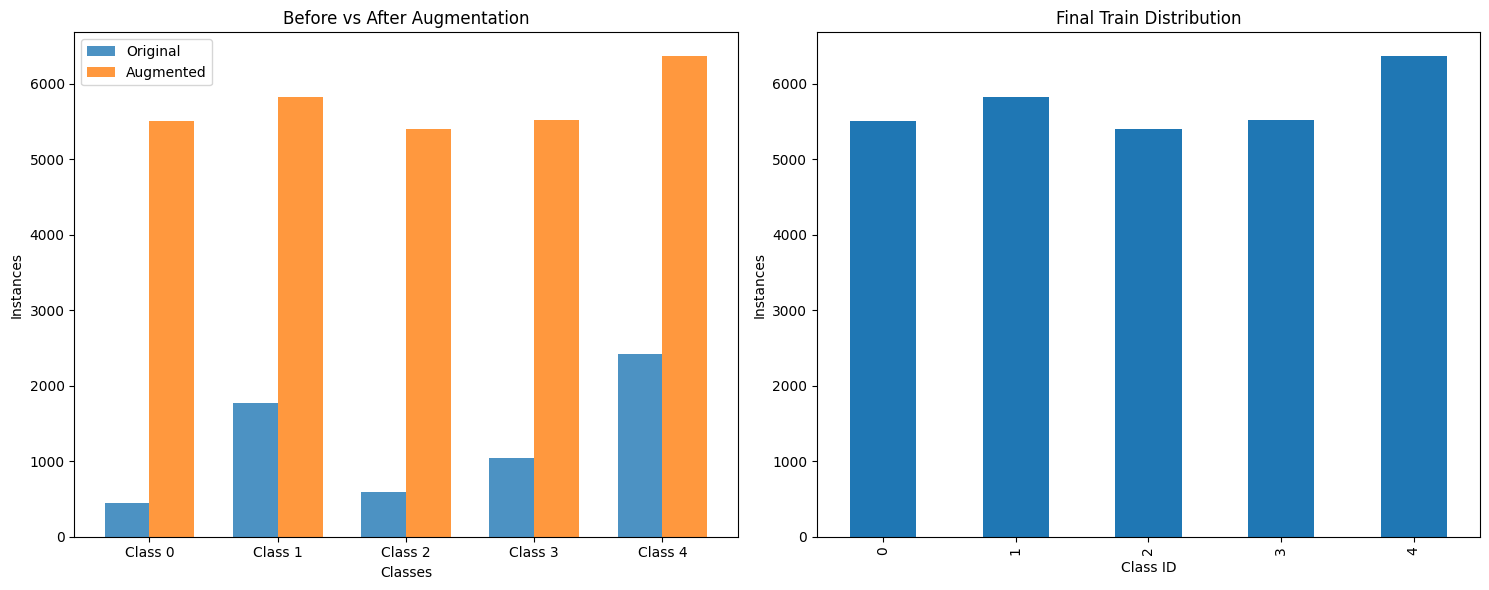


📈 Summary:
  Original training instances: 6274
  Final training instances: 28633
  Total increase: +22359 (+356.4%)
  Class balance ratio: 0.85 (1.0 = perfect balance)
  ✅ Dataset is well balanced!

🎉 Augmentation pipeline completed successfully!
Dataset available at: /home/andrea/work/AI-waste-detection/src/data_processing/roboflow_augmented
Structure:
  ├── train/
  │   ├── images/ (original + augmented + synthetic)
  │   └── labels/
  ├── test/ (copied from original)
  │   ├── images/
  │   └── labels/
  └── data.yaml


In [18]:
# Run the complete augmentation pipeline
if TARGET_CLASSES and NUM_CLASSES > 0:
    print("🚀 Starting Dataset Augmentation Pipeline...")
    print(f"Classes to process: {TARGET_CLASSES}")
    
    # Create the augmented dataset
    augmented_dataset_path = create_augmented_dataset()
    
    if augmented_dataset_path:
        print(f"\n✅ Augmented dataset created at: {augmented_dataset_path}")
        
        # Verify the results
        final_dist = verify_augmented_dataset()
        
        print(f"\n🎉 Augmentation pipeline completed successfully!")
        print(f"Dataset available at: {ROBOFLOW_AUGMENTED_DIR}")
        print(f"Structure:")
        print(f"  ├── train/")
        print(f"  │   ├── images/ (original + augmented + synthetic)")
        print(f"  │   └── labels/")
        print(f"  ├── test/ (copied from original)")
        print(f"  │   ├── images/")
        print(f"  │   └── labels/")
        print(f"  └── data.yaml")
    else:
        print("❌ Failed to create augmented dataset")
else:
    print("❌ Cannot proceed: No target classes found or dataset not properly loaded.")
    print("Please check that the roboflow dataset exists and has a valid data.yaml file.")

## 8. Optional: Quick Dataset Statistics

In [19]:
# Quick statistics about the created dataset
def show_dataset_statistics():
    """Show quick statistics about the augmented dataset."""
    if not ROBOFLOW_AUGMENTED_DIR.exists():
        print("Augmented dataset not found.")
        return
    
    train_img_dir = ROBOFLOW_AUGMENTED_DIR / 'train/images'
    train_label_dir = ROBOFLOW_AUGMENTED_DIR / 'train/labels'
    test_img_dir = ROBOFLOW_AUGMENTED_DIR / 'test/images'
    test_label_dir = ROBOFLOW_AUGMENTED_DIR / 'test/labels'
    
    # Count files
    train_images = len(list(train_img_dir.glob('*'))) if train_img_dir.exists() else 0
    train_labels = len(list(train_label_dir.glob('*'))) if train_label_dir.exists() else 0
    test_images = len(list(test_img_dir.glob('*'))) if test_img_dir.exists() else 0
    test_labels = len(list(test_label_dir.glob('*'))) if test_label_dir.exists() else 0
    
    print("📊 Dataset Statistics:")
    print(f"  Training set: {train_images} images, {train_labels} labels")
    print(f"  Test set: {test_images} images, {test_labels} labels")
    print(f"  Total: {train_images + test_images} images")
    
    # Count different types of training images
    if train_img_dir.exists():
        # Count original images (no special prefix/suffix)
        original_count = len([f for f in train_img_dir.glob('*') 
                            if not any(keyword in f.stem for keyword in ['_aug_', 'aug_synthetic', 'pure_synthetic'])])
        
        # Count traditional augmentations (contain '_aug_')
        traditional_aug_count = len([f for f in train_img_dir.glob('*') if '_aug_' in f.stem and not f.stem.startswith('aug_synthetic')])
        
        # Count augmented synthetic (start with 'aug_synthetic')
        aug_synthetic_count = len([f for f in train_img_dir.glob('*') if f.stem.startswith('aug_synthetic')])
        
        # Count pure synthetic (start with 'pure_synthetic')
        pure_synthetic_count = len([f for f in train_img_dir.glob('*') if f.stem.startswith('pure_synthetic')])
        
        total_synthetic = aug_synthetic_count + pure_synthetic_count
        
        print(f"\n📈 Training set breakdown:")
        print(f"  Original images: {original_count}")
        print(f"  Traditional augmentations: {traditional_aug_count}")
        print(f"  Synthetic images total: {total_synthetic}")
        print(f"    ├── Augmented synthetic: {aug_synthetic_count}")
        print(f"    └── Pure synthetic: {pure_synthetic_count}")
        
        # Show percentages
        if train_images > 0:
            print(f"\n📊 Distribution percentages:")
            print(f"  Original: {(original_count/train_images)*100:.1f}%")
            print(f"  Traditional augmentations: {(traditional_aug_count/train_images)*100:.1f}%")
            print(f"  Synthetic: {(total_synthetic/train_images)*100:.1f}%")
            
            if total_synthetic > 0:
                aug_ratio = aug_synthetic_count / total_synthetic
                pure_ratio = pure_synthetic_count / total_synthetic
                print(f"\n🎨 Synthetic data distribution:")
                print(f"  Augmented synthetic: {aug_ratio:.1%} (target: {AUGMENTED_SYNTHETIC_RATIO:.1%})")
                print(f"  Pure synthetic: {pure_ratio:.1%} (target: {PURE_SYNTHETIC_RATIO:.1%})")
                
                # Show if we're close to target distribution
                aug_diff = abs(aug_ratio - AUGMENTED_SYNTHETIC_RATIO)
                if aug_diff < 0.1:  # Within 10%
                    print(f"  ✅ Synthetic distribution matches target well!")
                else:
                    print(f"  ⚠️  Synthetic distribution differs from target by {aug_diff:.1%}")

# Show statistics
show_dataset_statistics()

📊 Dataset Statistics:
  Training set: 16081 images, 16081 labels
  Test set: 1099 images, 1099 labels
  Total: 17180 images

📈 Training set breakdown:
  Original images: 4361
  Traditional augmentations: 6236
  Synthetic images total: 5484
    ├── Augmented synthetic: 3839
    └── Pure synthetic: 1645

📊 Distribution percentages:
  Original: 27.1%
  Traditional augmentations: 38.8%
  Synthetic: 34.1%

🎨 Synthetic data distribution:
  Augmented synthetic: 70.0% (target: 70.0%)
  Pure synthetic: 30.0% (target: 30.0%)
  ✅ Synthetic distribution matches target well!


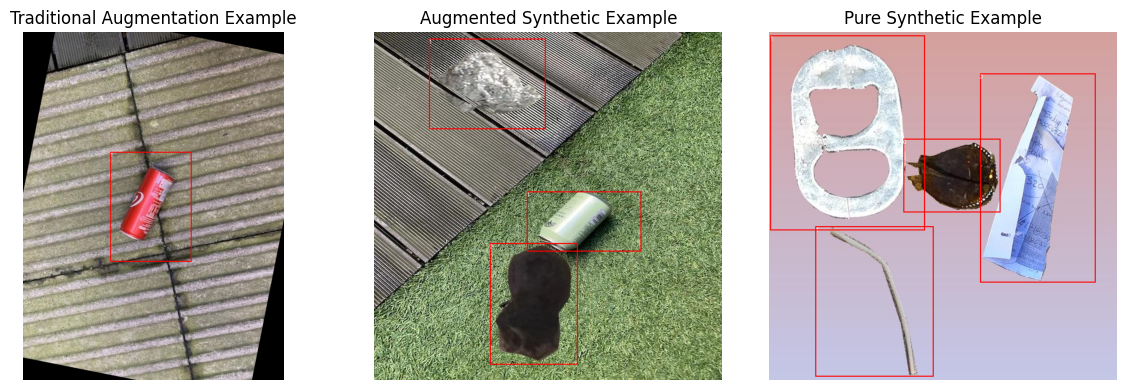

In [24]:
def show_image_with_bboxes(image_path, label_path, title, ax):
    """Show an image with bounding boxes from a YOLO label file on a given axis."""
    img = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(img)
    
    if label_path.exists():
        with open(label_path, 'r') as f:
            for line in f:
                if line.strip():
                    parts = line.split()
                    class_id = int(float(parts[0]))
                    cx, cy, w, h = map(float, parts[1:])
                    img_width, img_height = img.size
                    x1 = int((cx - w / 2) * img_width)
                    y1 = int((cy - h / 2) * img_height)
                    x2 = int((cx + w / 2) * img_width)
                    y2 = int((cy + h / 2) * img_height)
                    draw.rectangle([x1, y1, x2, y2], outline='red', width=2)
                    draw.text((x1, y1), str(class_id), fill='white')
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')

def show_example_images():
    """Show example images with bounding boxes in a single figure."""
    if not ROBOFLOW_AUGMENTED_DIR.exists():
        print("Augmented dataset not found.")
        return
    
    train_img_dir = ROBOFLOW_AUGMENTED_DIR / 'train/images'
    train_label_dir = ROBOFLOW_AUGMENTED_DIR / 'train/labels'
    
    traditional_example = next(train_img_dir.glob('*_aug_*.jpg'), None)
    aug_synthetic_example = next(train_img_dir.glob('aug_synthetic_*.jpg'), None)
    pure_synthetic_example = next(train_img_dir.glob('pure_synthetic_*.jpg'), None)
    
    examples = [
        (traditional_example, "Traditional Augmentation Example"),
        (aug_synthetic_example, "Augmented Synthetic Example"),
        (pure_synthetic_example, "Pure Synthetic Example")
    ]
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    found = False
    for i, (img_path, title) in enumerate(examples):
        if img_path:
            label_file = train_label_dir / f"{img_path.stem}.txt"
            show_image_with_bboxes(img_path, label_file, title, axes[i])
            found = True
        else:
            axes[i].axis('off')
            axes[i].set_title(f"No {title.lower()}")
    plt.tight_layout()
    plt.show()
    if not found:
        print("No example images found in the augmented dataset.")

show_example_images()
